* SHAP stands for SHapley Additive exPlanations.
* It leverages the concept of game theory to break down a prediction to measure the impact of each feature.
* Shap displays the effect of the feature at on prediction at a certain value than if the feature was at a baseline value.

In this notebook we will work with the well known [Adult Income dataset](https://archive.ics.uci.edu/ml/datasets/adult) and perform the following steps:

* Train a XGBoost model on the given dataset.
* Compute the Shapley values to explain the individual feature contributions.
* Visualize these values and interpret them.
Let's get started!

In [1]:
!pip install shap -q

### Importing necessary libraries

In [2]:
import numpy as np   
import pandas as pd  

# Visualization Libraries
import matplotlib.pyplot as plt
%matplotlib inline

## Machine learning packages
from sklearn.model_selection import train_test_split
import xgboost as xgb

## Model Interpretation package
import shap
shap.initjs()

# Ensuring Reproducability
SEED = 12345

# Ignoring the warnings
import warnings  
warnings.filterwarnings(action = "ignore")

## Loading the Dataset


Let’s read in the data and look at the first few rows

In [3]:
X,y = shap.datasets.adult()
X_view,y_view = shap.datasets.adult(display=True)


In [4]:
# Let's look at the first few rows in the dataset
X_view.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [5]:
y_view

array([False, False, False, ..., False, False,  True])

In [6]:
# X_view is only for displaying the unprocesses data. X is the pre-processed version 
# where categorial columns have been encoded
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             32561 non-null  float32
 1   Workclass       32561 non-null  int8   
 2   Education-Num   32561 non-null  float32
 3   Marital Status  32561 non-null  int8   
 4   Occupation      32561 non-null  int8   
 5   Relationship    32561 non-null  int64  
 6   Race            32561 non-null  int8   
 7   Sex             32561 non-null  int8   
 8   Capital Gain    32561 non-null  float32
 9   Capital Loss    32561 non-null  float32
 10  Hours per week  32561 non-null  float32
 11  Country         32561 non-null  int8   
dtypes: float32(5), int64(1), int8(6)
memory usage: 1.1 MB


The dataset doesn't contain any null values and none of them re categorical.

### Train/Validation/Test Split
Splitting the dataset into train and validation sets.

In [7]:
# create a train/test split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=7)
print(X_train.shape, X_valid.shape)

(26048, 12) (6513, 12)


## Training a XGB Model

In [8]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

In [9]:
%%time 
# Feed the model the global bias
base_score = np.mean(y_train)

#Set hyperparameters for model training
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.01,
    'subsample': 0.5,
    'colsample_bytree': 0.8,
    'max_depth': 5,
    'base_score': base_score,
    'seed': SEED
}

# Train using early stopping on the validation dataset.
watchlist = [(dtrain, 'X_train'), (dvalid, 'X_valid')]

model = xgb.train(params,         
                        dtrain,                   
                        num_boost_round=5000,                     
                        evals=watchlist,
                        early_stopping_rounds=20,
                        verbose_eval=100)


[0]	X_train-logloss:0.54807	X_valid-logloss:0.54668
[100]	X_train-logloss:0.37095	X_valid-logloss:0.37302
[200]	X_train-logloss:0.32264	X_valid-logloss:0.32653
[300]	X_train-logloss:0.30273	X_valid-logloss:0.30786
[400]	X_train-logloss:0.29148	X_valid-logloss:0.29756
[500]	X_train-logloss:0.28378	X_valid-logloss:0.29111
[600]	X_train-logloss:0.27854	X_valid-logloss:0.28717
[700]	X_train-logloss:0.27463	X_valid-logloss:0.28454
[800]	X_train-logloss:0.27158	X_valid-logloss:0.28270
[900]	X_train-logloss:0.26889	X_valid-logloss:0.28122
[1000]	X_train-logloss:0.26654	X_valid-logloss:0.28022
[1100]	X_train-logloss:0.26448	X_valid-logloss:0.27951
[1200]	X_train-logloss:0.26249	X_valid-logloss:0.27878
[1300]	X_train-logloss:0.26069	X_valid-logloss:0.27835
[1400]	X_train-logloss:0.25900	X_valid-logloss:0.27813
[1457]	X_train-logloss:0.25803	X_valid-logloss:0.27803
CPU times: user 56.5 s, sys: 229 ms, total: 56.7 s
Wall time: 14.3 s


For more information on the configurable parameters within the XGBoost module, see the [documentation](https://xgboost.readthedocs.io/en/latest/parameter.html) 



# Explaining Model Behavior with SHAP

## Calculating SHAP values

In [10]:
%%time 
explainer = shap.TreeExplainer(model=model)
shap_values = explainer.shap_values(X)
print('Expected Value:', explainer.expected_value)


Expected Value: -1.14309
CPU times: user 4min 12s, sys: 116 ms, total: 4min 12s
Wall time: 1min 4s


In [11]:
# Printing shap values matrix containing samples and features
pd.DataFrame(shap_values)[:5]

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.183729,-0.202140,0.584135,-0.487027,-0.327518,-1.013560,0.013128,0.167152,-1.398924,-0.059405,-0.216103,0.013624
1,0.420581,-0.358894,0.575480,0.164483,0.347297,0.499771,0.023126,0.034714,-0.212994,-0.102625,-1.235385,0.014056
2,0.101235,0.020639,-0.508364,-0.378206,-0.755975,-1.127960,0.017213,0.124767,-0.198456,-0.056498,-0.171413,0.001993
3,0.493745,0.005381,-1.287940,0.171015,-0.755869,0.560124,-0.203344,0.057790,-0.220106,-0.085327,-0.062476,0.016916
4,-0.660579,-0.023258,0.728090,0.227092,0.208664,1.164945,-0.354244,-0.174569,-0.200329,-0.090759,-0.064996,-0.228426


## SHAP Force Plot

Let's generate force plot for the 10th person in the dataset and see which feature impact the income more than the others. The target value for this person is `True` i.e the person earns ≥ $50K annually.

In [12]:
y[0]

False

In [13]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:],X.iloc[0,:])


## SHAP Summary plot

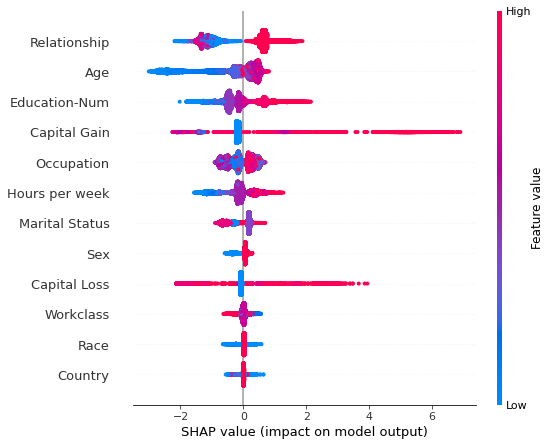

In [14]:
shap.summary_plot(shap_values, X)

## Training a XGB Model on GPU

In [15]:
#Enabling GPU 
!nvidia-smi

Tue Sep 20 05:40:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
%%time
# Feed the model the global bias
base_score = np.mean(y_train)

#Set hyperparameters for model training
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.01,
    'subsample': 0.5,
    'colsample_bytree': 0.8,
    'max_depth': 5,
    'base_score': base_score,
    'tree_method': "gpu_hist", # GPU accelerated training
    'seed': SEED
}

# Train using early stopping on the validation dataset.
watchlist = [(dtrain, 'X_train'), (dvalid, 'X_test')]

model_gpu = xgb.train(params,         
                        dtrain,                   
                        num_boost_round=5000,                     
                        evals=watchlist,
                        early_stopping_rounds=10,
                        verbose_eval=100)

[0]	X_train-logloss:0.54812	X_test-logloss:0.54672
[100]	X_train-logloss:0.37164	X_test-logloss:0.37370
[200]	X_train-logloss:0.32311	X_test-logloss:0.32705
[300]	X_train-logloss:0.30309	X_test-logloss:0.30826
[400]	X_train-logloss:0.29164	X_test-logloss:0.29789
[500]	X_train-logloss:0.28401	X_test-logloss:0.29128
[600]	X_train-logloss:0.27890	X_test-logloss:0.28733
[700]	X_train-logloss:0.27495	X_test-logloss:0.28461
[800]	X_train-logloss:0.27193	X_test-logloss:0.28270
[900]	X_train-logloss:0.26922	X_test-logloss:0.28132
[1000]	X_train-logloss:0.26690	X_test-logloss:0.28033
[1100]	X_train-logloss:0.26482	X_test-logloss:0.27947
[1200]	X_train-logloss:0.26301	X_test-logloss:0.27884
[1241]	X_train-logloss:0.26221	X_test-logloss:0.27865
CPU times: user 2.43 s, sys: 484 ms, total: 2.91 s
Wall time: 3.27 s


## Explaining Model Behavior with SHAP using GPU

In [17]:
%%time
model_gpu.set_param({"predictor": "gpu_predictor"})
explainer_gpu = shap.TreeExplainer(model=model_gpu)
shap_values_gpu = explainer_gpu.shap_values(X)

CPU times: user 1.34 s, sys: 252 ms, total: 1.59 s
Wall time: 1.56 s
